In [1]:
from sklearn.mixture import GaussianMixture
from matplotlib import pyplot as plt
from matplotlib import cm, colors
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import numpy as np

from collections import Counter
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

np.set_printoptions(linewidth=300, suppress=True)

from src.experiments.util_experiments import *
from src.oom import DiscreteValuedOOM, ContinuousValuedOOM

In [2]:
n, d, density = 3, 10, 0.2
seed_dv, seed_mf = 63, 6

oom_cont = ContinuousValuedOOM.from_discrete_valued_oom(
    dvoom = make_source(alphabet_size=n, dimension=d, density=density, seed=seed_dv),
    membership_functions = get_gaussian(seed=seed_mf)(n)
)

In [3]:
gen = oom_cont.generate(10000, reduced=True)
data = np.array(gen.sequence_cont).reshape(-1, 1)

mixture = GaussianMixture(
    n_components = 3,
    covariance_type='full',
    init_params = 'random_from_data',
    max_iter = 1000,
    tol = 1e-5,
    random_state = 0
)
mixture.fit(data)

means_gmm = mixture.means_ 
covs_gmm  = mixture.covariances_
weights_gmm = mixture.weights_

In [4]:
def plot_mfs(cvoom, fig, ax, title, xlim = (-5, 5)):
    xlimi, xlims = xlim
    ax.set_title(title)
    ax.set_xlim([xlimi, xlims])
    
    x = np.linspace(xlimi, xlims, (xlims - xlimi) * 1000)
    for obs, mf in zip(cvoom.observables, cvoom.membership_fns):
        ax.plot(x, mf.pdf(x), label=obs.uid)
    ax.legend()

    ax.spines['left'].set_position('zero')
    ax.spines['bottom'].set_position('zero')
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

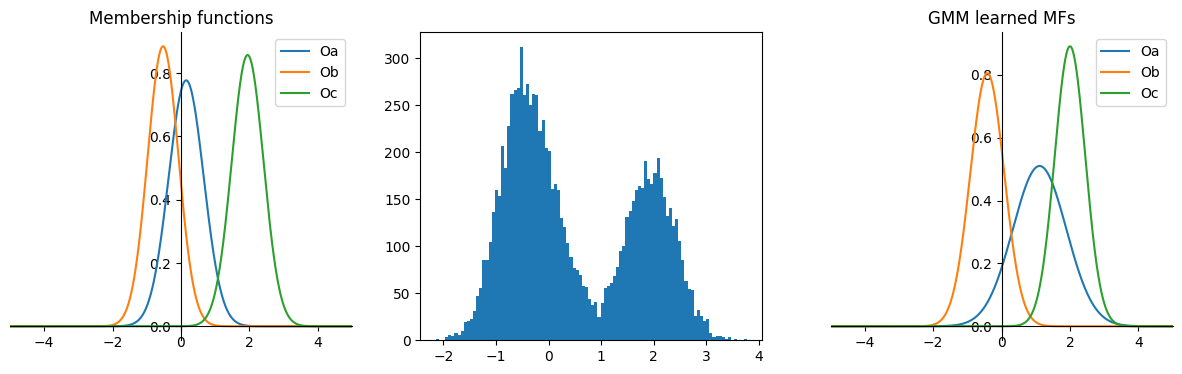

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
axs = axs.flatten()

pdfs = []
for idx in range(3):
    pdf = sp.stats.norm(loc = means_gmm[idx][0], scale = np.sqrt(covs_gmm[idx][0][0]))
    pdfs.append(pdf)
oom_proxy = ContinuousValuedOOM(
             start_state = oom_cont.start_state,
       linear_functional = oom_cont.lin_func,
                 obs_ops = dict(zip(oom_cont.observables, oom_cont.operators)),
    membership_functions = pdfs,
                     dim = oom_cont.dim,
)

plot_mfs(oom_cont, fig, axs[0], "Membership functions")
axs[1].hist(gen.sequence_cont, bins=100)
plot_mfs(oom_proxy, fig, axs[2], "GMM learned MFs")

plt.show()

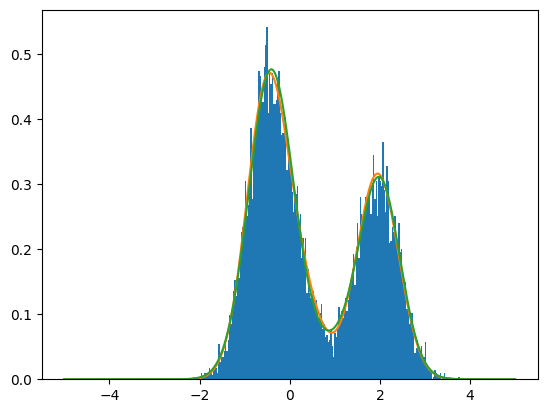

In [7]:
import scipy as sp

X = np.linspace(-5, 5, 10000)

ser = pd.Series([obs.uid for obs in gen.sequence])
ser = ser.value_counts(normalize = True)
ser = ser.sort_index(key = lambda x: x.str.ljust(5, 'z'))
weights_data = ser.values
weights_gmm = weights_gmm

gmm_pdfs = pdfs

wpdf_data = np.average(np.array([mf.pdf(X) for mf in oom_cont.membership_fns]), weights=weights_data, axis=0)
wpdf_gmm = np.average(np.array([mf.pdf(X) for mf in gmm_pdfs]), weights=weights_gmm, axis=0)

plt.figure()
plt.hist(gen.sequence_cont, bins=200, density=True)
plt.plot(X, wpdf_data)
plt.plot(X, wpdf_gmm)
plt.show()

In [8]:
mfs_props = []
for mf in oom_cont.membership_fns:
    mfs_props.append(mf.__dict__['kwds'])
mfs_props_df = pd.DataFrame.from_records(mfs_props)
mfs_props_df = mfs_props_df.rename({'loc': 'mean', 'scale': 'var'}, axis = 1).sort_values(by = 'mean')
mfs_props_df

,mean,var
1,-0.523731,0.451006
0,0.152657,0.513458
2,1.949780,0.465513


In [9]:
mfs_props_gmm = []
for mf in gmm_pdfs:
    mfs_props_gmm.append(mf.__dict__['kwds'])
mfs_props_gmm_df = pd.DataFrame.from_records(mfs_props_gmm)
mfs_props_gmm_df = mfs_props_gmm_df.rename({'loc': 'mean', 'scale': 'var'}, axis = 1).sort_values(by = 'mean')
mfs_props_gmm_df

,mean,var
1,-0.416948,0.495434
0,1.112768,0.782207
2,2.001814,0.447887


In [13]:
l2_distance_gmm(weights_data, oom_cont.membership_fns, weights_gmm, gmm_pdfs)

0.0003380387598126422

In [14]:
mixture.bic(data)

27683.837769432892

In [167]:
def cv_gmm(data_cont, length, val_size, use_l2=False, true_weights=None, true_pdfs=None):
    val_size = int(0.1 * length)
    train_data = data_cont[:-val_size]

    metrics = {"n1": [], "nll": [], "bic": []}
    if use_l2:
        metrics["l2"] = []

    for n1 in range(2, 20):
        gmm = GaussianMixture(
            n_components = n1,
            covariance_type='full',
            init_params = 'random_from_data',
            max_iter = 1000,
            tol = 1e-5,
            random_state = 0
        )
        gmm.fit(train_data)

        val_data = data_cont[-val_size : ]
        nll_here = -gmm.score(val_data)
        bic_here = gmm.bic(val_data)

        metrics["n1"].append(n1)
        metrics["nll"].append(nll_here)
        metrics["bic"].append(bic_here)

        if use_l2:
            means_gmm = gmm.means_ 
            covs_gmm  = gmm.covariances_
            weights_gmm = gmm.weights_
            
            pdfs_gmm = []
            for idx in range(n1):
                pdf = sp.stats.norm(loc = means_gmm[idx][0], scale = np.sqrt(covs_gmm[idx][0][0]))
                pdfs_gmm.append(pdf)
            
            l2_here = l2_distance_gmm(true_weights, true_pdfs, weights_gmm, pdfs_gmm)
            metrics["l2"].append(l2_here)
    return metrics

length = 10000
gen = oom_cont.generate(length, reduced=True)

val_size = int(0.1 * length)
ser = pd.Series([obs.uid for obs in gen.sequence[ : -val_size]])
ser = ser.value_counts(normalize = True)
ser = ser.sort_index(key = lambda x: x.str.ljust(5, 'z'))
weights_data = ser.values

data = np.array(gen.sequence_cont).reshape(-1, 1)

metrics = cv_gmm(data, length, val_size, use_l2=True, true_weights=weights_data, true_pdfs=oom_cont.membership_fns)
metrics = pd.DataFrame(metrics)
metrics

,n1,nll,bic,l2
0,2,1.408537,2851.612369,0.000673
1,3,1.405508,2866.277233,0.000319
2,4,1.405569,2887.123913,0.000500
3,5,1.408268,2913.245503,0.000270
4,6,1.408459,2934.350508,0.000370
5,7,1.408643,2955.440997,0.000359
6,8,1.410946,2980.769827,0.000937
7,9,1.411183,3001.967002,0.000965
8,10,1.411293,3022.911299,0.000908
9,11,1.412974,3046.996394,0.000946


In [168]:
metrics["bic_norm"] = (metrics["bic"] - metrics["bic"].min())/(metrics["bic"].max() - metrics["bic"].min())
metrics["nll_norm"] = (metrics["nll"] - metrics["nll"].min())/(metrics["nll"].max() - metrics["nll"].min())
metrics["l2_norm"] = (metrics["l2"] - metrics["l2"].min())/(metrics["l2"].max() - metrics["l2"].min())
metrics["wa_bic_l2"] = 0.5 * metrics["bic_norm"] + 0.5 * metrics["l2_norm"]
metrics["wa_nll_l2"] = 0.5 * metrics["nll_norm"] + 0.5 * metrics["l2_norm"]

print(f"Best n1 judging by BIC: {metrics.sort_values('bic_norm', ascending=True)['n1'].iloc[0]}")
print(f"Best n1 judging by NLL: {metrics.sort_values('nll_norm', ascending=True)['n1'].iloc[0]}")
print(f"Best n1 judging by BIC+L2: {metrics.sort_values('wa_bic_l2', ascending=True)['n1'].iloc[0]}")
print(f"Best n1 judging by NLL+L2: {metrics.sort_values('wa_nll_l2', ascending=True)['n1'].iloc[0]}")

Best n1 judging by BIC: 2
Best n1 judging by NLL: 3
Best n1 judging by BIC+L2: 3
Best n1 judging by NLL+L2: 3


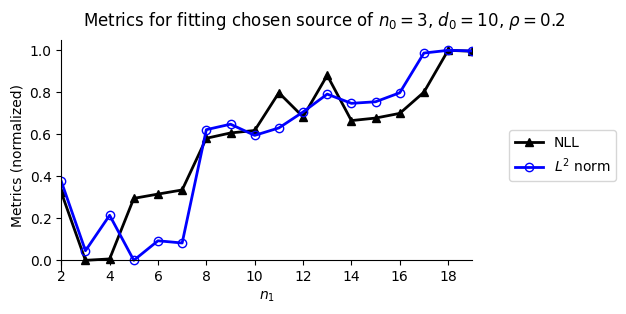

In [175]:
# BIC scores (full dots)
# plt.scatter(metrics["n1"], metrics["bic_norm"], c = 'k', ls = '-', lw = 1, edgecolors='k', mw label = "BIC")
fig, axs = plt.subplots(1, 2, figsize = (7, 3), width_ratios=[1, 0.2])
axs = axs.flatten()
ax, legendax = axs[0], axs[1]

fig.suptitle(f"Metrics for fitting chosen source of $n_0={n}$, $d_0={d}$, $\\rho={density}$")

ax.plot(metrics["n1"], metrics["nll_norm"], c = 'k', ls = '-', lw = 2,
         marker='^', ms = 6, mec='k', mfc='k', label = "NLL")

# ax.plot(metrics["n1"], metrics["wa_nll_l2"], c = 'b', ls = '--', lw = 2,
#          marker='^', ms = 5, mec='b', mfc='none', label = "(NLL+$L^2$)/2")

ax.plot(metrics["n1"], metrics["l2_norm"], c = 'b', ls = '-', lw = 2,
         marker='o', ms = 6, mec='b', mfc='none', label = "$L^2$ norm")

# ax.plot(metrics["n1"], metrics["wa_bic_l2"], c = 'r', ls = '--', lw = 2,
#          marker='s', ms = 5, mec='r', mfc='none', label = "(BIC+$L^2$)/2")

# ax.plot(metrics["n1"], metrics["bic_norm"], c = 'k', ls = '-', lw = 2,
#          marker='s', ms = 5, mec='k', mfc='k', label = "BIC")

ax.set_xlabel("$n_1$")
ax.set_xlim([metrics["n1"].min(), metrics["n1"].max()])
ax.set_ylabel("Metrics (normalized)")


ax.spines['bottom'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

handles, labels = ax.get_legend_handles_labels()
legendax.legend(handles, labels, loc='center')
legendax.spines['top'].set_visible(False)
legendax.spines['bottom'].set_visible(False)
legendax.spines['left'].set_visible(False)
legendax.spines['right'].set_visible(False)
legendax.set_xticks([])
legendax.set_yticks([])

plt.show()

In [199]:
from typing import Callable

def l2_distance_gmm(weights_true, pdfs_true, weights_gmm, pdfs_gmm):
    """
    Compute the squared L2 distance between two Gaussian Mixture Models (GMMs).

    Parameters:
        weights_true (np.array): Coefficients of the true GMM.
        pdfs_true (list of scipy.stats.norm): List of norm objects for the true GMM.
        weights_gmm (np.array): Coefficients of the learned GMM.
        pdfs_gmm (list of scipy.stats.norm): List of norm objects for the learned GMM.

    Returns:
        float: Squared L2 distance between the two GMMs.
    """
    # Helper function to compute the integral of the product of two Gaussians
    def gaussian_product_integral(mu1, sigma1, mu2, sigma2):
        sigma_sum = sigma1 + sigma2
        return sp.stats.norm.pdf(mu1, loc=mu2, scale=np.sqrt(sigma_sum))

    # Compute the self-interaction term for the true GMM
    true_self_term = 0.0
    for i in range(len(weights_true)):
        for j in range(len(weights_true)):
            true_self_term += weights_true[i] * weights_true[j] * gaussian_product_integral(
                pdfs_true[i].mean(), pdfs_true[i].std()**2,
                pdfs_true[j].mean(), pdfs_true[j].std()**2
            )

    # Compute the self-interaction term for the learned GMM
    gmm_self_term = 0.0
    for i in range(len(weights_gmm)):
        for j in range(len(weights_gmm)):
            gmm_self_term += weights_gmm[i] * weights_gmm[j] * gaussian_product_integral(
                pdfs_gmm[i].mean(), pdfs_gmm[i].std()**2,
                pdfs_gmm[j].mean(), pdfs_gmm[j].std()**2
            )

    # Compute the cross-interaction term between the true and learned GMMs
    cross_term = 0.0
    for i in range(len(weights_true)):
        for j in range(len(weights_gmm)):
            cross_term += weights_true[i] * weights_gmm[j] * gaussian_product_integral(
                pdfs_true[i].mean(), pdfs_true[i].std()**2,
                pdfs_gmm[j].mean(), pdfs_gmm[j].std()**2
            )

    # Compute the squared L2 distance
    l2_squared = true_self_term + gmm_self_term - 2 * cross_term
    return l2_squared


def get_from_gmm(
    data: np.array,
    ret_metrics: bool = True,
    true_pdfs: Optional[list[Callable]] = None,
    true_seqweights: Optional[list[float]] = None
) -> list[Callable] | tuple[list[Callable], dict[str, float]]:
    """
    Models input data using a Gaussian Mixture model. This function internally performs
    cross-validation using 90% of data as train and 10% as validation. It will report the
    optimal membership function estimates, chosen based on the validation NLL. Optionally,
    it can report the NLL metric and even the L2 distance to another (target) GMM.

    Args:
        data: the array of observation data to use in the clustering task
        ret_metrics: whether to return metrics together with the membership function estimates
        true_pdfs: the true PDFs expected to be modeled by the GMM (if this parameter and
            `true_seqweights` are both provided, the L2 distance between GMMs will also be
            computed)
        true_seqweights: the weighing of each true PDF in the Gaussian mixture which is expected
            to be modeled by this GMM (if this parameter and `true_pdfs` are both provided, the
            L2 distance between GMMs will also be computed)

    Returns:
        A Python list of scipy.stats.rv_continuous objects representing the Gaussians composing
        the best GMM after cross-validation. If ret_metrics is true, a dictionary of metric names
        and metric values containing the best GMM's evaluation is also returned, resulting in a
        tuple (list, dict)
    """
    length = len(data)
    
    val_size = int(0.1 * length)
    train_data = data[ : -val_size]
    val_data = data[-val_size : ]
    
    metrics = {"est_alphabet_size": [], "nll": []}
    
    for est_alphabet_size in range(2, 20):
        # Fit a GMM on the (split) train set
        gmm = GaussianMixture(
            n_components = est_alphabet_size,
            covariance_type = "full",
            init_params = "random_from_data",
            max_iter = 1000,
            tol = 1e-5,
            random_state = 0
        )
        gmm.fit(train_data)

        # Assess GMM on validation data and record result
        nll_here = -gmm.score(val_data)
        metrics["est_alphabet_size"].append(est_alphabet_size)
        metrics["nll"].append(nll_here)

    # Sort by NLL and get alphabet size for lowest NLL
    metrics_df = pd.DataFrame(metrics).sort_values("nll", ascending = True)
    best_alphabet_size = metrics_df["est_alphabet_size"].iloc[0]
    best_nll = metrics_df["nll"].iloc[0]

    # Fit GMM using entire training sequence (without validation split)
    best_gmm = GaussianMixture(
        n_components = best_alphabet_size,
        covariance_type = "full",
        init_params = "random_from_data",
        max_iter = 1000,
        tol = 1e-5,
        random_state = 0
    )
    best_gmm.fit(data)

    # Get PDFs from this best GMM
    means_gmm = best_gmm.means_ 
    covs_gmm  = best_gmm.covariances_
    weights_gmm = best_gmm.weights_
    
    pdfs_best_gmm = []
    for idx in range(best_alphabet_size):
        pdf = sp.stats.norm(loc = means_gmm[idx][0], scale = np.sqrt(covs_gmm[idx][0][0]))
        pdfs_best_gmm.append(pdf)

    results_metrics = {"alphabet_size": best_alphabet_size, "nll": best_nll}
    
    if true_pdfs is not None and true_seqweights is not None:
        l2_here = l2_distance_gmm(true_seqweights, true_pdfs, weights_gmm, pdfs_best_gmm)
        results_metrics["l2"] = l2_here

    if ret_metrics:
        return pdfs_best_gmm, results_metrics
    return pdfs_best_gmm

In [200]:
length = 10000
gen = oom_cont.generate(length, reduced=True)
data = np.array(gen.sequence_cont).reshape(-1, 1)

ser = pd.Series([obs.uid for obs in gen.sequence[ : -val_size]])
ser = ser.value_counts(normalize = True)
ser = ser.sort_index(key = lambda x: x.str.ljust(5, 'z'))
weights_data = ser.values

empirical_mfs, metrics_gmm = get_from_gmm(data, true_pdfs=oom_cont.membership_fns, true_seqweights=weights_data)

In [201]:
metrics_gmm

{'alphabet_size': 5, 'nll': 1.3984070921144338, 'l2': 0.000397365905902225}

In [202]:
for emf in empirical_mfs:
    print(emf.__dict__['kwds'])

{'loc': -0.144613736736813, 'scale': 0.4048995756233203}
{'loc': -0.6142070578830838, 'scale': 0.26527381461680566}
{'loc': 1.4766687387529227, 'scale': 0.7068315484652707}
{'loc': 1.983760713554234, 'scale': 0.4309006034719054}
{'loc': -0.9676360425587126, 'scale': 0.3362562470942683}


In [7]:
dicts = [
    {'hi': 1, 'bye': 3},
    {'hi': 2, 'bye': 6, 'sy': 6, 'bau': 9},
    {'hi': 4, 'bye': 9},
]

In [8]:
import pandas as pd
pd.DataFrame.from_records(dicts)

,hi,bye,sy,bau
0,1,3,NaN,NaN
1,2,6,6.0,9.0
2,4,9,NaN,NaN
